# Quem fez o ENEM em 2016 apenas para treinar?

O intuito do desafio é identificar por meio dos dados qual dos participantes do ENEM 2016 fez a prova com o intuito de testar suas habilidades.

Disponibilizados os datasets **train.csv** e **test.csv**, o resultado deverá ser um arquivo chamado **answer.csv** contendo apenas o número de inscrição do participante (coluna *NU_INSCRICAO*) e a variável predita *IN_TREINEIRO*. O [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip) está disponível para o melhor entendimento do significado das variáveis do problema.

## 1) importar as bibliotecas  e alguns parâmetros gráficos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, confusion_matrix, roc_curve,roc_auc_score, classification_report

In [2]:
plt.rc('figure', figsize=(10,6))
sns.set(style='white', palette='GnBu_d')

## 2) Carregar e preparar os dados para Análise Exploratória

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.shape, test.shape

((13730, 167), (4570, 43))

Verifica-se que os datasets tem formas diferentes. O conjunto menor de features (dataset de treino) está contido no maior?

In [5]:
set(test.columns).issubset(train.columns)

True

Perfeito! Devemos então obter respostas unicamente a partir do conjunto de features de teste, semelhantemente ao problema anterior. Vamos também já eliminar as colunas de identificação de ambos os datasets, já que não se espera que o modelo aprenda algo inesperado proveniente delas.
Vamos então fazer com que os datasets possuam as mesmas colunas para poder seguir. Também é conveniente eliminar a variável *NU_INSCRICAO*, já que por princípo ela não deve influenciar na nota do participante sendo só um identificador, e sua presença geraria um ruído indesejado no treino e teste dos modelos.

In [6]:
y_train = train['IN_TREINEIRO']
x_train = train[test.columns]
x_train = x_train.drop(columns = ['NU_INSCRICAO'])
test = test.drop(columns = ['NU_INSCRICAO'])

In [7]:
print(x_train.shape, test.shape)
print(x_train.columns == test.columns)

(13730, 42) (4570, 42)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


Feito! Limpamos o dataset de treino. Agora podemos partir para a análise exploratória dos dados  de ambos os datasets e fazer uma boa seleção de features para treinar mais eficientemente possivel o(s) nosso(s) modelo(s).

## 3)Análise exploratória dos dados

### 3.1 Detecção e tratamento de *Missing values*  

A função `nanplot` abaixo pode nos dar um gráfico mostrando em ordem a quantidade de *missing values*, ou *valores faltantes* em cada coluna. É importante analisarmos tanto o dataset de treino quanto o de teste, visto que ambos necessariamente precisam passar pelas mesmas características e transformações afim de serem semelhantes ao final. Adicionalmente, também é bom avaliar nossa variável alvo à procur de algum valor faltante lá.

In [8]:
def nanplot(df, title):
    nan_df = (df.isna().sum()/df.shape[0]).sort_values()
    
    plt.figure(figsize=(20,20))
    plt.barh(y=nan_df.index,width=nan_df.values*100)
    plt.title(title,fontsize=25)
    for index,value in enumerate(nan_df):
        plt.text((value*100)+.25,index-0.25,'{}%'.format(round(value*100,2)))
    plt.ylabel('Features',fontsize=20)
    plt.xlabel('Faltantes(%)',fontsize=20)

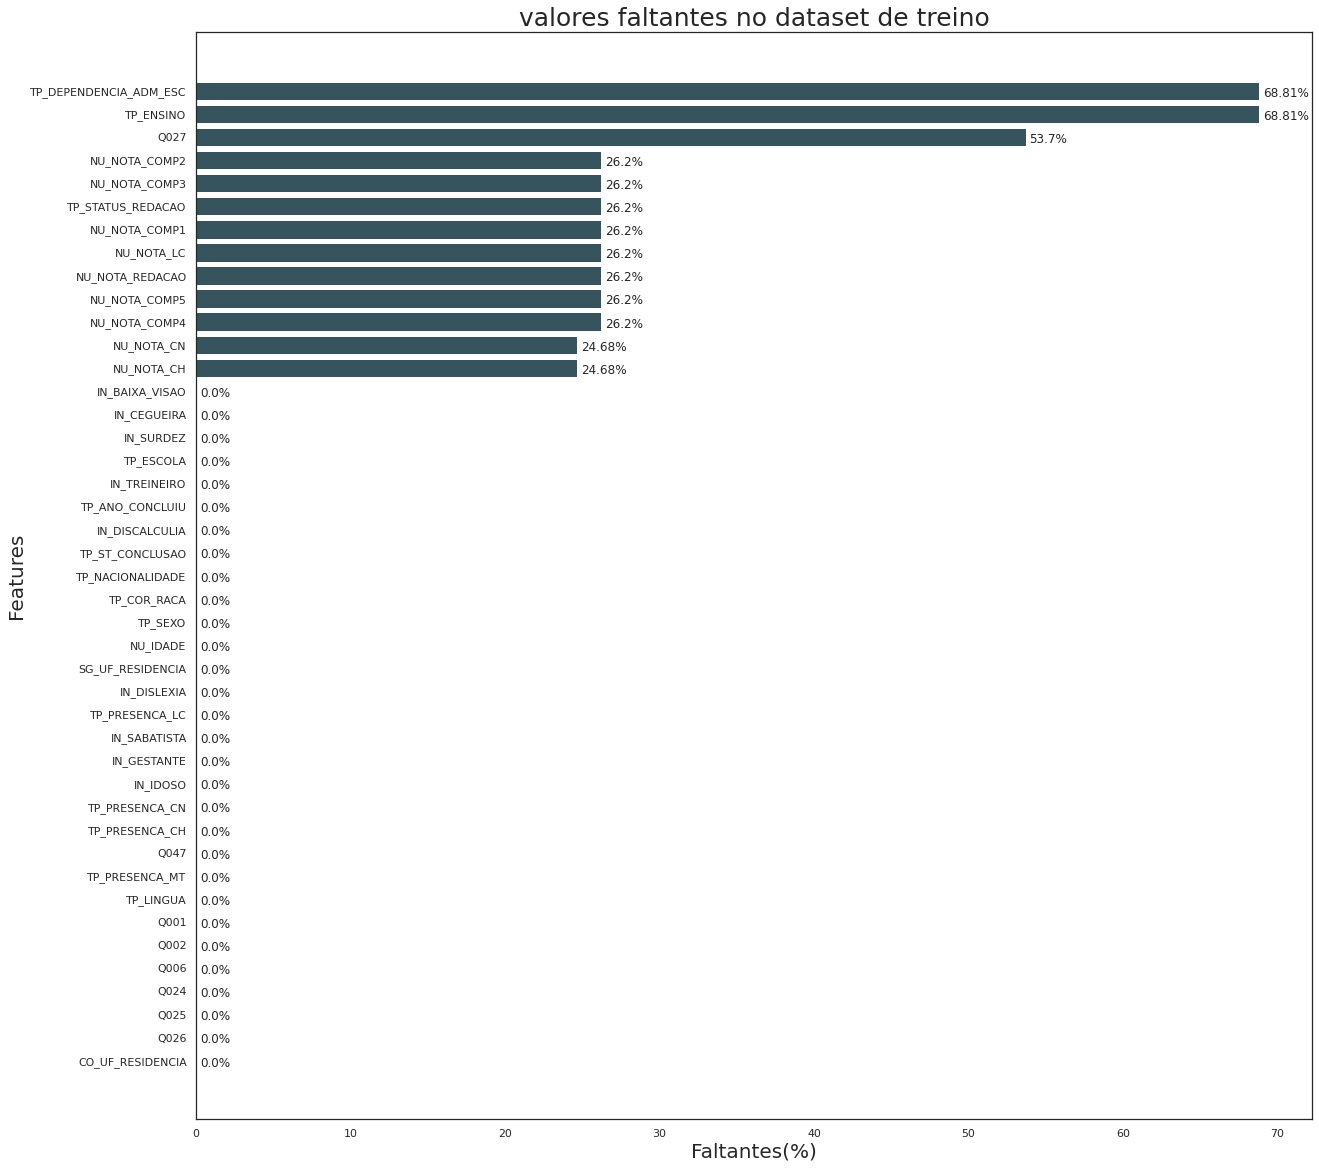

In [9]:
train_df = pd.concat([x_train,y_train], axis=1)
nanplot(train_df,'valores faltantes no dataset de treino')

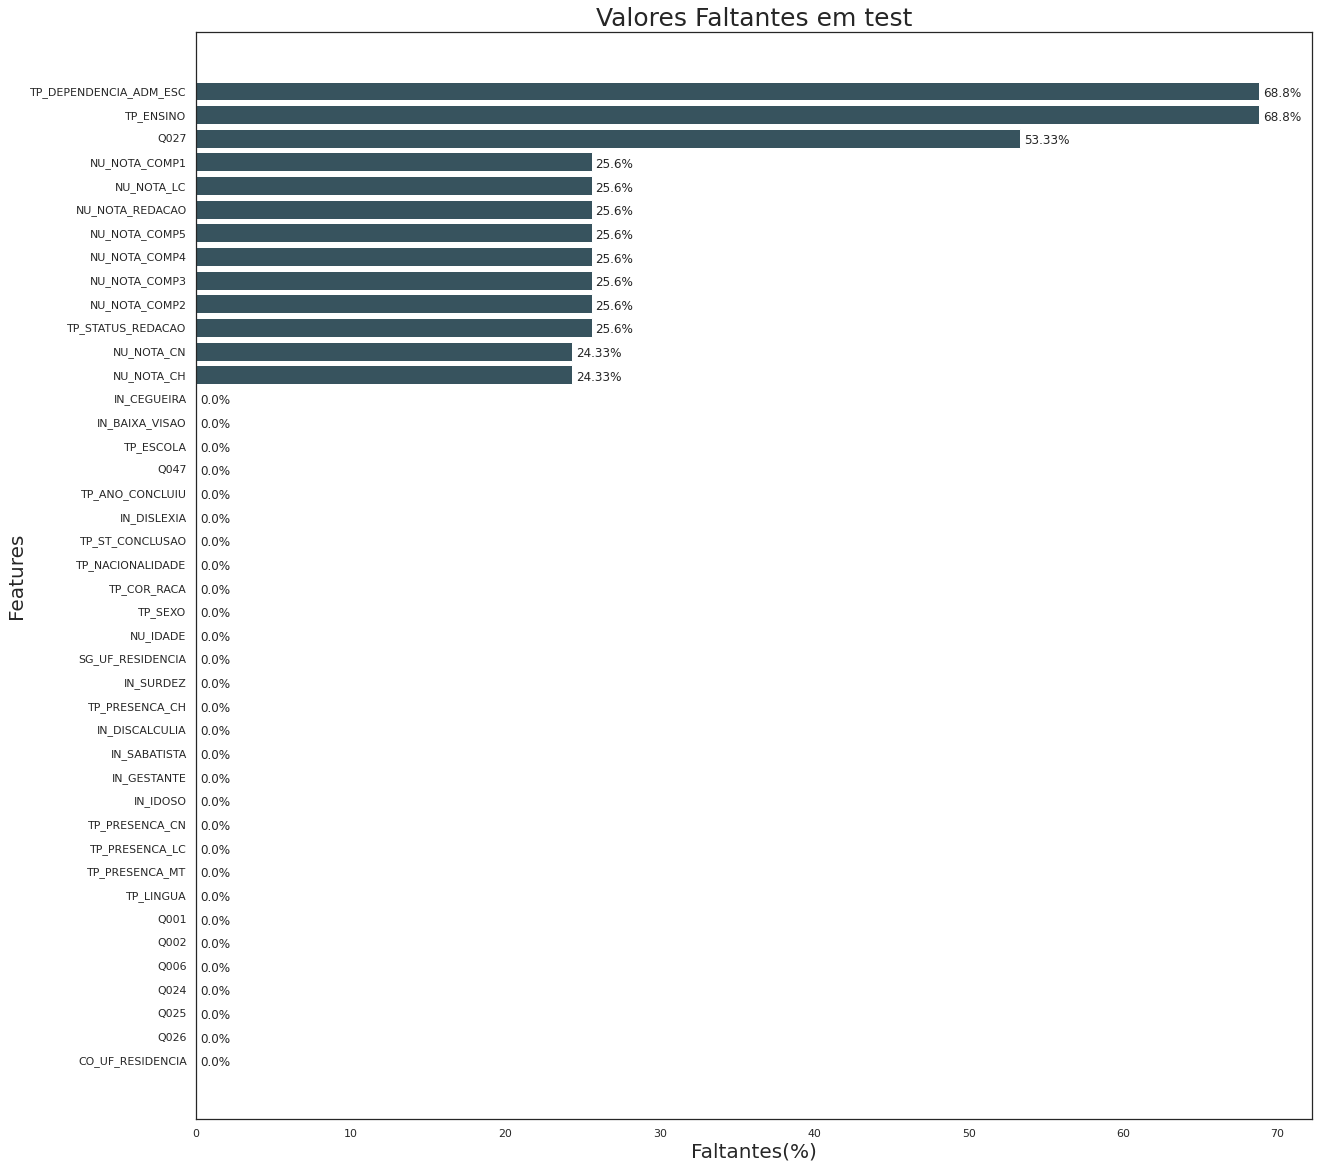

In [10]:
nanplot(test,'Valores Faltantes em test')

Algumas variáveis apresentam dados faltantes. Nomeadamente, as variáveis *TP_DEPENDENCIA_ADM_ESC,TP_ENSINO* e *Q027* tem mais da metade de seus dados faltantes, e as restantes apresentam cerca de um quarto de seus valores faltantes ou estão totalmente completas. Como devemos lidar com isso?

Algumas alternativas comumente realizadas são:

* Eliminar todas as observações(linhas) que contém um valor faltante;
* Preencher os faltantes com valores associados à distribuição dos dados (Como a média ou mediana da distribuição);
* Evidenciar a existência dele como um valor faltante, atribuindo um valor fora dos limites da distribuição dos dados;

As variáveis com mais da metade de missing values nãao acrescentarão novas informações que sejam de valor caso as completemos de alguma forma, já que temos aproximadamente 30% dos seus valores preenchidos, não teremos valores médios ou medianas confiáveis. Optei por eliminá-las.

às variáveis restantes, optei por imputar o valor **-1**, 'sinalizando sua inexistência'. Os datasets de treino e teste apresentam uma situação semelhante, de maneira que podemos aplicar esse mesmo procedimento em ambos.

In [11]:
to_drop = ['TP_DEPENDENCIA_ADM_ESC','TP_ENSINO','Q027']

x_train = x_train.drop(columns=to_drop)
test = test.drop(columns=to_drop)


In [12]:
x_train.fillna(-1,inplace = True)
test.fillna(-1,inplace=True)

In [13]:
x_train.shape,test.shape

((13730, 39), (4570, 39))

In [14]:
x_train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

### 3.2) Balanceamento

In [15]:
def class_balance(cat,title):
    
    sns.countplot(cat)
    
    plt.ylabel('Contagem',fontsize=20)
    plt.xlabel('Classes Presentes',fontsize=20)
    plt.title(title, fontsize=24)
    plt.ylim([0,cat.shape[0]])
    cat_percentages = cat.value_counts(normalize = True)
    
    for (pos,percentage) in zip(cat_percentages.index,cat_percentages.values):
        percent_text = '{}%'.format(round(percentage*100,2))
        plt.annotate(percent_text, (pos-0.06, percentage*cat.shape[0] + 100),fontsize=20)

    

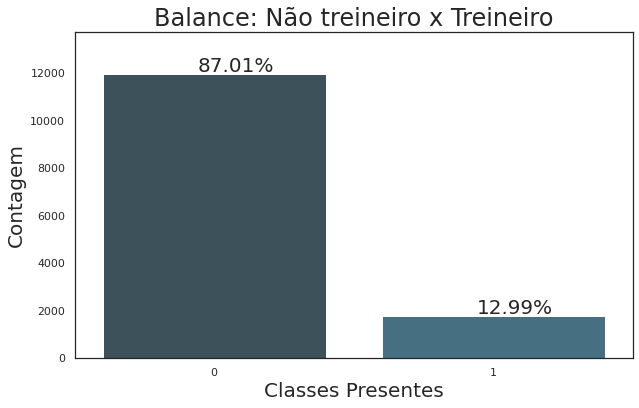

In [16]:
class_balance(y_train,'Balance: Não treineiro x Treineiro')

In [17]:
def enem_feat_sep(cols, sep_rule):
    non_numeric = [col for col in cols if col[:2] in sep_rule]
    numeric = [col for col in cols if col[:2] not in sep_rule]
    return non_numeric,numeric

In [18]:
cat_prefix = ['CO','TP','IN','Q0','SG']

cat_features, num_features = enem_feat_sep(x_train.columns,cat_prefix)

In [19]:
print('categóricas: ',cat_features)
print()
print('numéricas:',num_features)

categóricas:  ['CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047']

numéricas: ['NU_IDADE', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']


In [20]:
cat_train = x_train[cat_features]
num_train = x_train[num_features]

cat_test = test[cat_features]
num_test = test[num_features]

In [21]:
encode = OneHotEncoder(sparse=False, handle_unknown='ignore', dtype=np.int)

encode.fit(cat_train)

cat_train_encoded = encode.transform(cat_train)
cat_test_encoded = encode.transform(cat_test)

cat_train_encoded = pd.DataFrame(cat_train_encoded, columns=encode.get_feature_names(cat_features))
cat_train_encoded = pd.concat([cat_train_encoded,num_train.reset_index(drop=True)], axis=1)

cat_test_encoded = pd.DataFrame(cat_test_encoded, columns=encode.get_feature_names(cat_features))
cat_test_encoded = pd.concat([cat_test_encoded,num_test.reset_index(drop=True)], axis=1)


In [22]:
cat_train_encoded.shape, cat_test_encoded.shape

((13730, 183), (4570, 183))

In [23]:
smote = SMOTE()

x_train_balanceado, y_train_balanceado = smote.fit_resample(cat_train_encoded, y_train)

(23894, 183) (13730,)


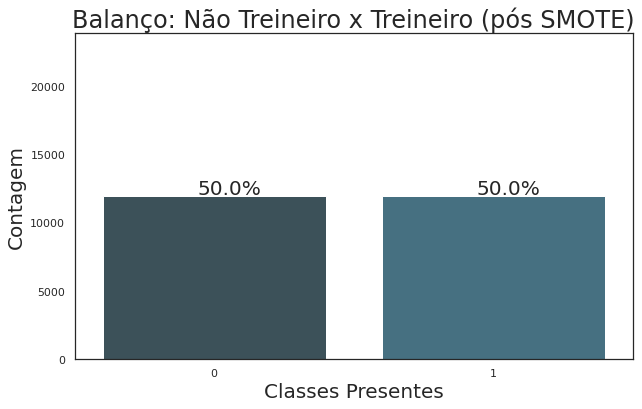

In [24]:
class_balance(y_train_balanceado,'Balanço: Não Treineiro x Treineiro (pós SMOTE)')
print(x_train_balanceado.shape, y_train.shape)

In [25]:
RANDOM_STATE = 69420

X_train, X_test, Y_train, Y_test = train_test_split(x_train_balanceado,y_train_balanceado, 
                                                    random_state = RANDOM_STATE, 
                                                    test_size = 0.3)

In [26]:
clfs = {
        'Random_Forest': RandomForestClassifier(random_state=RANDOM_STATE), 
        'Decision_Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'KNN': KNeighborsClassifier(n_neighbors=10)#,
        #'Logistic_Regression': LogisticRegression(max_iter=1000)
        }

In [27]:
for name in clfs.keys():
    clfs[name].fit(X_train,Y_train)
    print(f'Treinando modelo {name}')

Treinando modelo Random_Forest
Treinando modelo Decision_Tree
Treinando modelo KNN


In [28]:
print(clfs['Decision_Tree'].feature_importances_)
print()
print(clfs['Random_Forest'].feature_importances_)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.29438252e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.67655102e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.68452035e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.49506123e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.98004726e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.98669817e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.94870468e-04 5.55565681e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.25029665e-04
 0.00000000e+00 0.000000

In [29]:
df_importances = pd.DataFrame({'Random_Forest':pd.Series(clfs['Random_Forest'].feature_importances_),
                            'Decision_Tree':pd.Series(clfs['Decision_Tree'].feature_importances_),
                            'Feature':x_train_balanceado.columns})
df_importances.sort_values(by=['Random_Forest','Decision_Tree'], ascending = False)

,Random_Forest,Decision_Tree,Feature
69,0.244698,0.914521,TP_ST_CONCLUSAO_3
173,0.243059,0.077022,NU_IDADE
71,0.082402,0.000000,TP_ANO_CONCLUIU_0
68,0.074678,0.000000,TP_ST_CONCLUSAO_2
67,0.066072,0.000000,TP_ST_CONCLUSAO_1
...,...,...,...
94,0.000000,0.000000,IN_DISCALCULIA_1
99,0.000000,0.000000,IN_IDOSO_0
100,0.000000,0.000000,IN_IDOSO_1
109,0.000000,0.000000,TP_PRESENCA_LC_2


In [35]:
feats_rf = df_importances[df_importances['Random_Forest'] > df_importances['Random_Forest'].mean()]['Feature']
feats_dt = df_importances[df_importances['Decision_Tree'] > df_importances['Random_Forest'].mean()]['Feature']
print('Random Forest:', feats_rf.to_list())
print()
print('Decision Tree: ', feats_dt.to_list())

Random Forest: ['TP_ST_CONCLUSAO_1', 'TP_ST_CONCLUSAO_2', 'TP_ST_CONCLUSAO_3', 'TP_ST_CONCLUSAO_4', 'TP_ANO_CONCLUIU_0', 'TP_ANO_CONCLUIU_1', 'TP_ANO_CONCLUIU_10', 'TP_ESCOLA_1', 'TP_ESCOLA_2', 'Q001_B', 'Q006_C', 'Q026_A', 'Q026_B', 'Q026_C', 'NU_IDADE']

Decision Tree:  ['TP_ST_CONCLUSAO_3', 'NU_IDADE']


In [31]:
df_importances[df_importances['Random_Forest'] > df_importances['Random_Forest'].mean()]

,Random_Forest,Decision_Tree,Feature
67,0.066072,0.000000,TP_ST_CONCLUSAO_1
68,0.074678,0.000000,TP_ST_CONCLUSAO_2
69,0.244698,0.914521,TP_ST_CONCLUSAO_3
70,0.007484,0.000000,TP_ST_CONCLUSAO_4
71,0.082402,0.000000,TP_ANO_CONCLUIU_0
72,0.010043,0.000000,TP_ANO_CONCLUIU_1
81,0.005643,0.000000,TP_ANO_CONCLUIU_10
82,0.054897,0.000000,TP_ESCOLA_1
83,0.036841,0.000000,TP_ESCOLA_2
126,0.007606,0.000396,Q001_B


In [40]:
def plot_matriz_confusao(predict, teste_y, title):
    plt.figure(figsize=(6, 6))
    matriz_confusao = confusion_matrix(teste_y, predict)
    sns.heatmap(matriz_confusao, annot=True, fmt="d", cbar=False)
    plt.title(f"Matriz de Confusão - {title}", fontsize=20, pad=15)
    plt.xlabel("Previsto", fontsize=20, labelpad=15)
    plt.ylabel("Real", fontsize=20, labelpad=15)
    plt.xticks(ticks=[0.5, 1.5] ,labels=["Não-treineiro", "Treineiro"], fontsize=16)
    plt.yticks(ticks=[0.25 , 1.25] ,labels=["Não-treineiro", "Treineiro"], fontsize=16)
    plt.show()

def plota_roc_curve(fpr, tpr, predicoes, teste_y, label):
    plt.title("ROC Curve", fontsize=20)
    plt.ylabel("TPR or Sensitivity", fontsize=20)
    plt.xlabel("FPR or (1 - specificity)", fontsize=20)
    plt.plot(fpr, tpr, label=f"{label}")
    plt.plot([0, 1], [0, 1], ls="--", color="r", label="Sorte")
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.show()
    print(classification_report(teste_y, predicoes))
    print(f"AUC: {roc_auc_score(teste_y, predicoes)}")


In [42]:
def fit_predict(feat,model):
    clfs[model].fit(X_train[feat], Y_train)
    result = clfs[model].predict(X_test[feat])
    
    score = clfs[model].predict_proba(X_test[feat])[:,1]
    fpr,tpr,threshold = roc_curve(Y_test,score)
    plota_roc_curve(fpr,tpr,result,Y_test,model)
    
    return result

Random Forest

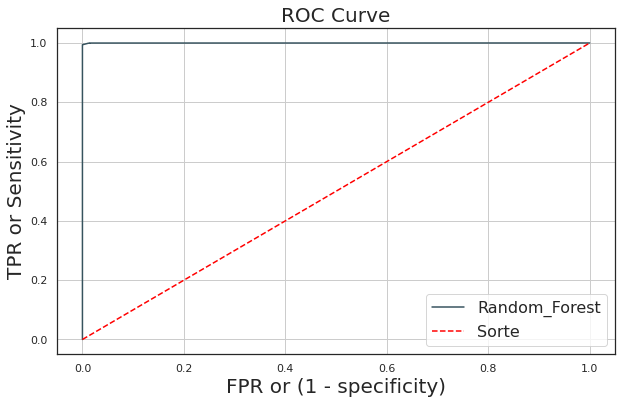

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3600
           1       1.00      0.99      1.00      3569

    accuracy                           1.00      7169
   macro avg       1.00      1.00      1.00      7169
weighted avg       1.00      1.00      1.00      7169

AUC: 0.9970579994396189


In [43]:
result_rf_frf = fit_predict(feats_rf,'Random_Forest')

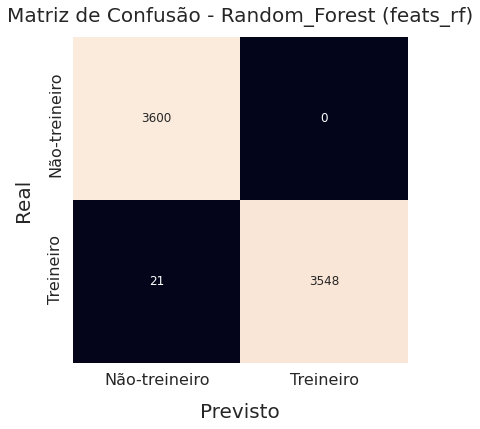

In [47]:
plot_matriz_confusao(result_rf_frf,Y_test,'Random_Forest (feats_rf)')

feat_dt

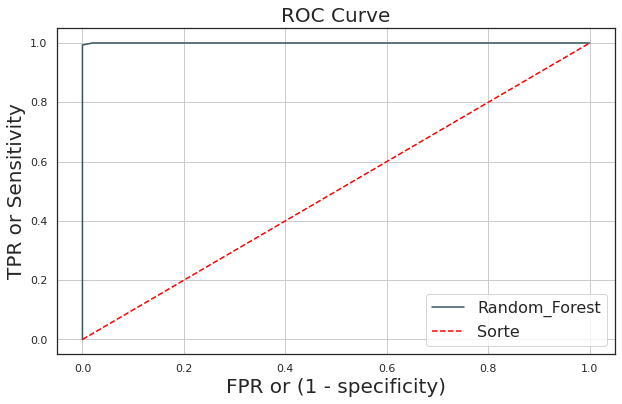

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3600
           1       1.00      0.99      1.00      3569

    accuracy                           1.00      7169
   macro avg       1.00      1.00      1.00      7169
weighted avg       1.00      1.00      1.00      7169

AUC: 0.9964976183804988


In [45]:
result_rf_fdt = fit_predict(feats_dt,'Random_Forest')

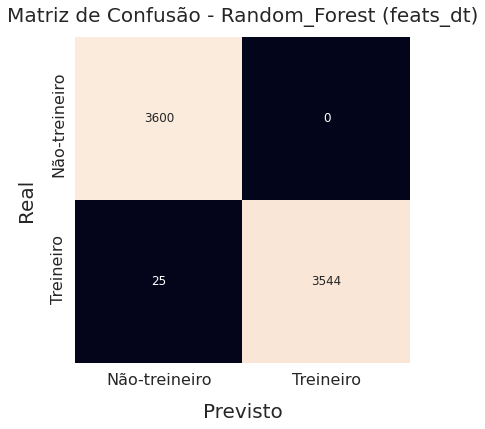

In [48]:
plot_matriz_confusao(result_rf_fdt,Y_test,'Random_Forest (feats_dt)')

Decision Tree

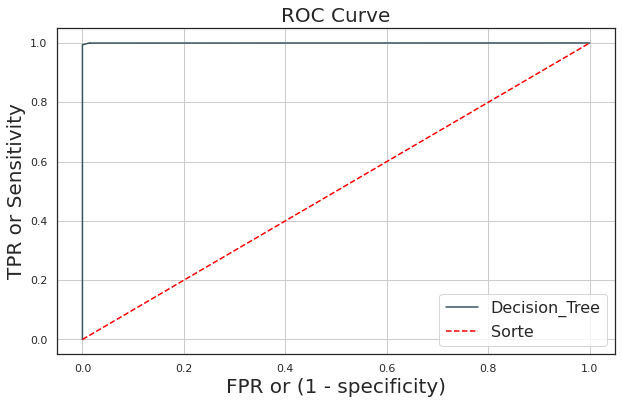

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3600
           1       1.00      0.99      1.00      3569

    accuracy                           1.00      7169
   macro avg       1.00      1.00      1.00      7169
weighted avg       1.00      1.00      1.00      7169

AUC: 0.9970579994396189


In [49]:
result_dt_frf = fit_predict(feats_rf,'Decision_Tree')

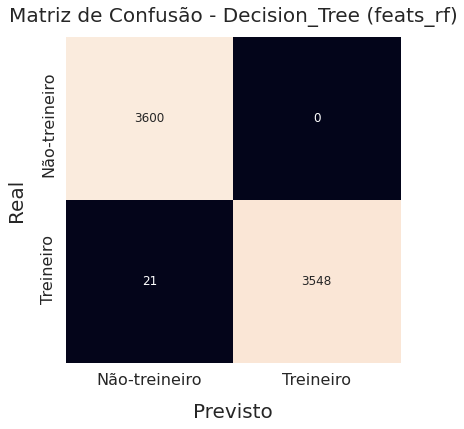

In [50]:
plot_matriz_confusao(result_dt_frf,Y_test,'Decision_Tree (feats_rf)')

feats_dt

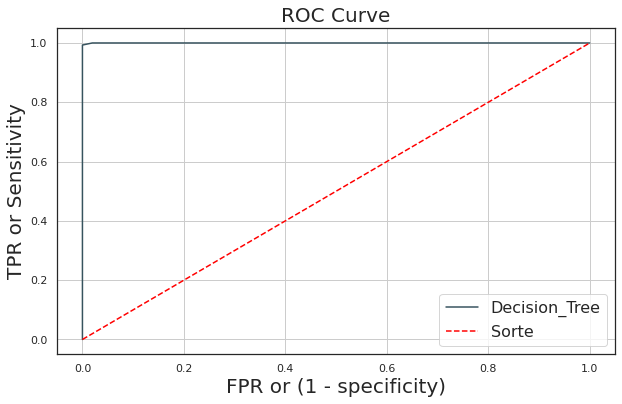

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3600
           1       1.00      0.99      1.00      3569

    accuracy                           1.00      7169
   macro avg       1.00      1.00      1.00      7169
weighted avg       1.00      1.00      1.00      7169

AUC: 0.9964976183804988


In [51]:
result_dt_fdt = fit_predict(feats_dt,'Decision_Tree')


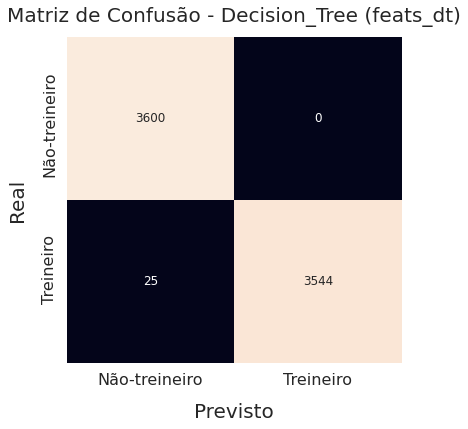

In [52]:
plot_matriz_confusao(result_dt_fdt,Y_test,'Decision_Tree (feats_dt)')


KNN

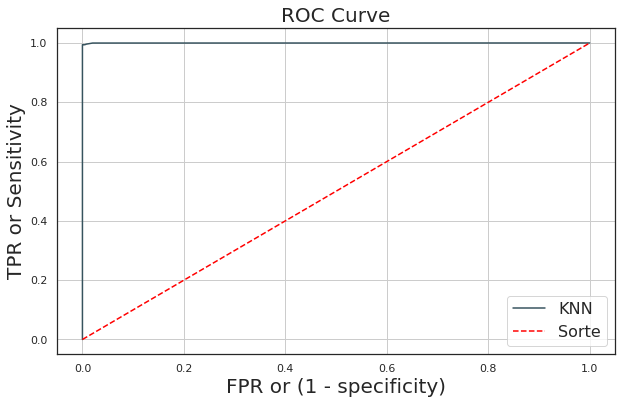

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3600
           1       1.00      0.99      1.00      3569

    accuracy                           1.00      7169
   macro avg       1.00      1.00      1.00      7169
weighted avg       1.00      1.00      1.00      7169

AUC: 0.9966413327729522


In [53]:
result_knn_frf = fit_predict(feats_rf,'KNN')

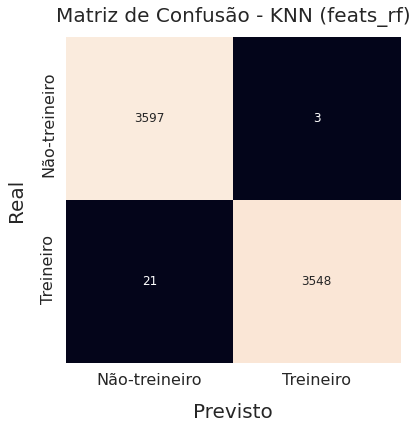

In [54]:
plot_matriz_confusao(result_knn_frf,Y_test,'KNN (feats_rf)')


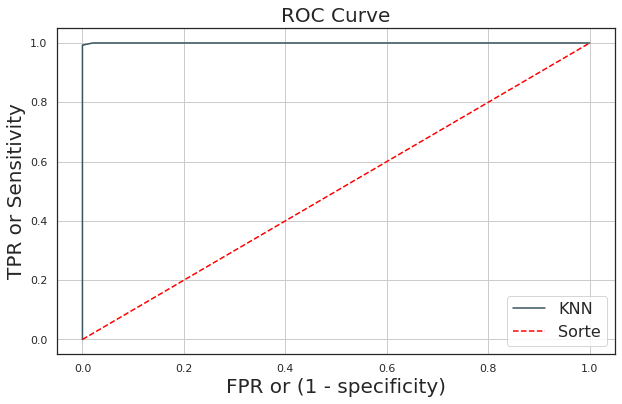

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3600
           1       1.00      0.99      1.00      3569

    accuracy                           1.00      7169
   macro avg       1.00      1.00      1.00      7169
weighted avg       1.00      1.00      1.00      7169

AUC: 0.9964976183804988


In [55]:
result_knn_fdt = fit_predict(feats_dt,'KNN')


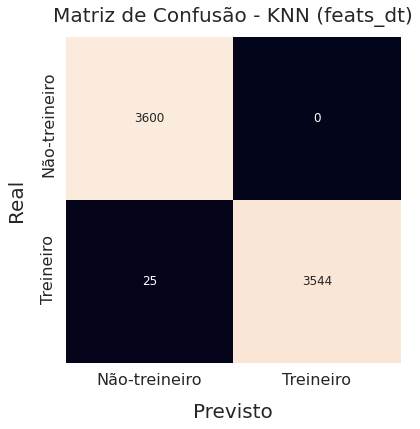

In [56]:
plot_matriz_confusao(result_knn_fdt,Y_test,'KNN (feats_dt)')


Submeter à codenation

In [64]:
IDs = pd.read_csv('test.csv')['NU_INSCRICAO']
for name,model in zip(clfs.keys(),clfs.values()):
    result = pd.Series(model.predict(cat_test_encoded[feats_dt]))
    final = pd.concat([IDs, result], axis=1)
    final.columns = ['NU_INSCRICAO','IN_TREINEIRO']
    filename = f'answer_{name}.csv'
    final.to_csv(filename,index=False)